# Transfer learning using ResNet50 model

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

# Part 1. Check how ResNet50 model classifies my images

## Load ResNet50 model
The model classifies images of size (224,224,3) to 1000 categories.
It was trained on ImageNet

In [2]:
model = tf.keras.applications.ResNet50(weights = 'imagenet')
print('model has',len(model.layers),'layers')
model.summary()

model has 177 layers
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________

## Load cats and dogs
The images are scaled to (224,224,3) to fit for ResNet50

In [3]:
import cv2
import os
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            image = cv2.resize(image, (224,224))
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('dataset')
print('loaded',len(samples),' samples')

print('classes',set(labels))

loaded 202  samples
classes {'cats', 'dogs'}


## Preprocess images to make them suitable for ResNet50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


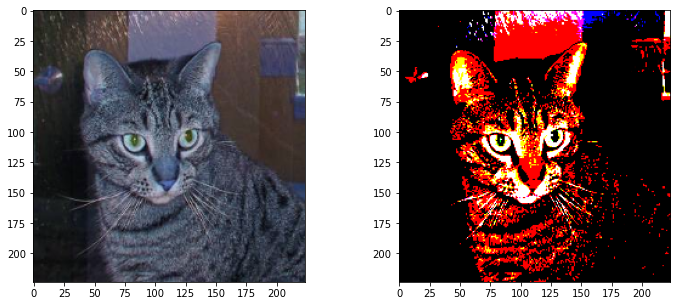

In [4]:
org_samples = samples[:]
samples = tf.keras.applications.resnet50.preprocess_input(samples)

## compare original and preprocessed
fig,(org_plot,prep_plot) = plt.subplots(1,2, figsize=(12, 5))
org_plot.imshow(org_samples[1])
prep_plot.imshow(samples[1])

## Use ResNet50 to classify my images

In [5]:
predictions = model.predict(samples)

### Analyse results

In [6]:
top3 = tf.keras.applications.resnet50.decode_predictions(predictions, top = 3)
for i in range(len(samples)):
#    print(labels[i],'->',top3[i])
    
## Pretty version
   print("{} -> ({}:{:.2f}, {}:{:.2f}, {}:{:.2f})".format(labels[i],
                top3[i][0][1],top3[i][0][2],
                top3[i][1][1],top3[i][1][2],
                top3[i][2][1],top3[i][2][2]))

cats -> (television:0.23, scorpion:0.08, laptop:0.04)
cats -> (tabby:0.54, tiger_cat:0.28, Egyptian_cat:0.15)
cats -> (tabby:0.36, lynx:0.14, feather_boa:0.11)
cats -> (lynx:0.35, tabby:0.19, Egyptian_cat:0.12)
cats -> (Egyptian_cat:0.72, Siamese_cat:0.15, Arctic_fox:0.04)
cats -> (tabby:0.45, Egyptian_cat:0.27, tiger_cat:0.08)
cats -> (Arctic_fox:0.61, Siamese_cat:0.10, lynx:0.04)
cats -> (Egyptian_cat:0.97, tabby:0.01, tiger_cat:0.01)
cats -> (Egyptian_cat:0.44, capuchin:0.10, lynx:0.10)
cats -> (tabby:0.55, tiger_cat:0.25, Egyptian_cat:0.17)
cats -> (Egyptian_cat:0.76, tabby:0.21, tiger_cat:0.03)
cats -> (Egyptian_cat:0.23, feather_boa:0.11, tabby:0.07)
cats -> (cocker_spaniel:0.57, giant_schnauzer:0.08, Afghan_hound:0.07)
cats -> (tabby:0.70, Egyptian_cat:0.22, tiger_cat:0.04)
cats -> (Siamese_cat:0.97, lynx:0.01, washbasin:0.00)
cats -> (tabby:0.60, Egyptian_cat:0.08, tiger_cat:0.07)
cats -> (tabby:0.35, bucket:0.23, tiger_cat:0.20)
cats -> (groenendael:0.73, schipperke:0.26, flat

### Some random examples

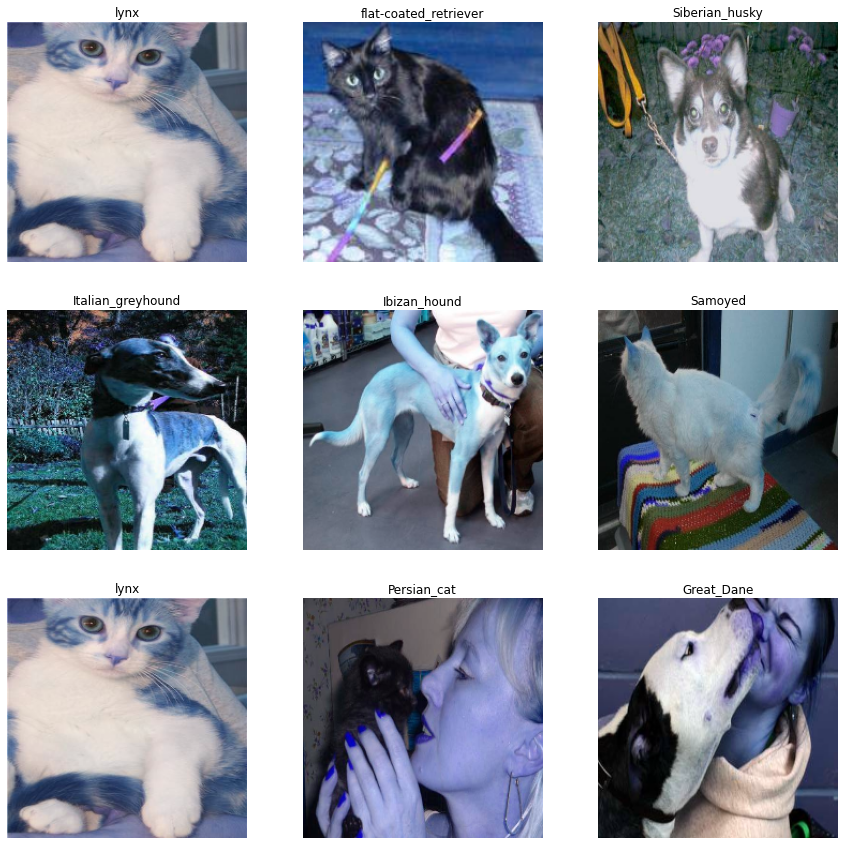

In [7]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(15, 15))
for i in range(9):
    n = random.randrange(len(samples))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(org_samples[n])
    plt.title(tf.keras.applications.resnet50.decode_predictions(predictions, top = 1)[n][0][1])
    plt.axis("off")

# Part 2. Use ResNet50 to classify cats and dogs - transfer learning

 ## Load ResNet50 without the dense part

In [8]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)
print("Layers:",len(base_model.layers))
#base_model.summary()

Layers: 175


### Compare models with and without the "top" part

In [9]:
print("Full model:",len(model.layers),'layers')
for i,layer in enumerate(model.layers[:3]):
    print("  ",i, layer.name, type(layer))
print('  ...')
for i,layer in enumerate(model.layers[171:]):
    print("  ",i+171, layer.name, type(layer))

print()
print("Base model:",len(base_model.layers),'layers')
for i,layer in enumerate(base_model.layers[:3]):
    print("  ",i, layer.name, type(layer))
print('  ...')
for i,layer in enumerate(base_model.layers[171:]):
    print("  ",i+171, layer.name, type(layer))

Full model: 177 layers
   0 input_1 <class 'tensorflow.python.keras.engine.input_layer.InputLayer'>
   1 conv1_pad <class 'tensorflow.python.keras.layers.convolutional.ZeroPadding2D'>
   2 conv1_conv <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
  ...
   171 conv5_block3_3_conv <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
   172 conv5_block3_3_bn <class 'tensorflow.python.keras.layers.normalization_v2.BatchNormalization'>
   173 conv5_block3_add <class 'tensorflow.python.keras.layers.merge.Add'>
   174 conv5_block3_out <class 'tensorflow.python.keras.layers.core.Activation'>
   175 avg_pool <class 'tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D'>
   176 predictions <class 'tensorflow.python.keras.layers.core.Dense'>

Base model: 175 layers
   0 input_2 <class 'tensorflow.python.keras.engine.input_layer.InputLayer'>
   1 conv1_pad <class 'tensorflow.python.keras.layers.convolutional.ZeroPadding2D'>
   2 conv1_conv <class 'tensorflow.python

### Build a model that uses ResNet as CNN part and has additional "dense" part

In [13]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
last_layer = tf.keras.layers.Dense(2, activation = 'softmax')(x)

model = tf.keras.models.Model(inputs = base_model.input, outputs = last_layer)

print("Combined model:",len(model.layers),'layers')

Combined model: 181 layers


### Set trainable=False for ResNet layers

In [14]:
for layer in model.layers[:175]:
    layer.trainable = False
    
for layer in model.layers[175:]:
    layer.trainable = True


### Encoding labels

In [15]:
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder() # encoder
intlabels = encoder.fit_transform(labels)
labels = tf.keras.utils.to_categorical(intlabels)
print("One-hot labels",labels.shape)

ValueError: y should be a 1d array, got an array of shape (202, 2) instead.

## Create and fit the model

In [16]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
print(samples.shape)
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,
                test_size=0.5
                #random_state=42
                )
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

checkpt = ModelCheckpoint (filepath='resnet50_model.h5', save_best_only=True)
estopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

EPOCHS = 5
H = model.fit(trainSamples, trainLabels, epochs=EPOCHS, batch_size=10, validation_data=(testSamples,testLabels),
             callbacks = [estopping,checkpt]) 
print("Done")

(202, 224, 224, 3)
Epoch 1/5
11/11 [==============================] - 22s 2s/step - loss: 1.2955 - accuracy: 0.6832 - val_loss: 1.1370 - val_accuracy: 0.5842
Epoch 2/5
11/11 [==============================] - 21s 2s/step - loss: 0.3974 - accuracy: 0.8713 - val_loss: 0.7598 - val_accuracy: 0.8218
Epoch 3/5
11/11 [==============================] - 18s 2s/step - loss: 0.2595 - accuracy: 0.9109 - val_loss: 0.5434 - val_accuracy: 0.8713
Epoch 4/5
11/11 [==============================] - 18s 2s/step - loss: 0.0595 - accuracy: 0.9703 - val_loss: 0.2007 - val_accuracy: 0.9604
Epoch 5/5
11/11 [==============================] - 18s 2s/step - loss: 0.0927 - accuracy: 0.9802 - val_loss: 0.5147 - val_accuracy: 0.8911
Done


### Show results

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
testResults = model.predict(testSamples)

print(confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print("CNN Accuracy: {:.2f}".format(accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
print("Cohen's Kappa: {:.2f}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))

[[41 11]
 [ 0 49]]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        52
           1       0.82      1.00      0.90        49

    accuracy                           0.89       101
   macro avg       0.91      0.89      0.89       101
weighted avg       0.91      0.89      0.89       101

CNN Accuracy: 0.89
Cohen's Kappa: 0.78


## Loss and accuracy in epochs

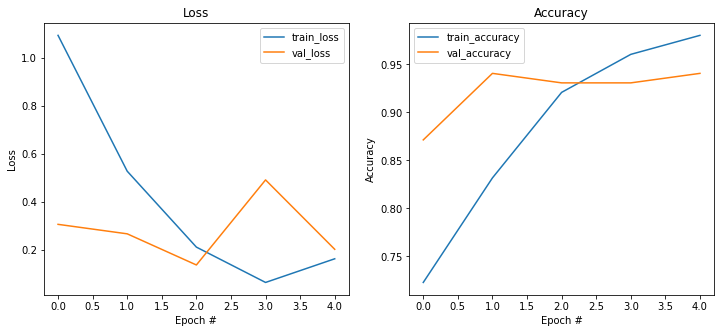

In [17]:
import matplotlib.pyplot as plt
N = np.arange(0, len(H.history["loss"]))

fig,(loss_plot,acc_plot) = plt.subplots(1,2, figsize=(12, 5))

loss_plot.plot(N, H.history["loss"], label="train_loss")
loss_plot.plot(N, H.history["val_loss"], label="val_loss")
loss_plot.set_title("Loss")
loss_plot.set(xlabel='Epoch #', ylabel='Loss')
loss_plot.legend()

acc_plot.plot(N, H.history["accuracy"], label="train_accuracy")
acc_plot.plot(N, H.history["val_accuracy"], label="val_accuracy")
acc_plot.set_title("Accuracy")
acc_plot.set(xlabel='Epoch #', ylabel='Accuracy')
acc_plot.legend()